# **Library Ingestion**
### Importing all necessary libraries for data science, visualization, and machine learning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# **Data Loading**
### Reading the Telco Customer Churn dataset into a DataFrame

In [ ]:
df = pd.read_csv('Telco-Customer-Churn.csv')
print(f"Dataset Loaded: {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

Dataset Loaded: 7043 rows and 21 columns


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **EDA - Structural Overview**
### Checking column names, types, and non-null counts to identify data cleaning needs

In [ ]:
print("--- Data Information ---")
print(df.info())
print("\n--- Missing Values Check ---")
print(df.isnull().sum())

--- Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling 

# **EDA - Target Variable Analysis**
### Visualizing the balance of the Churn label in the dataset

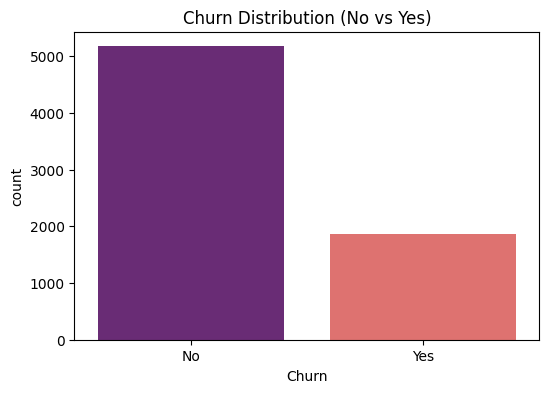

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='magma')
plt.title('Churn Distribution (No vs Yes)')
plt.show()

# **EDA - Numerical Distributions**
### Plotting histograms to understand the spread of tenure and monthly charges

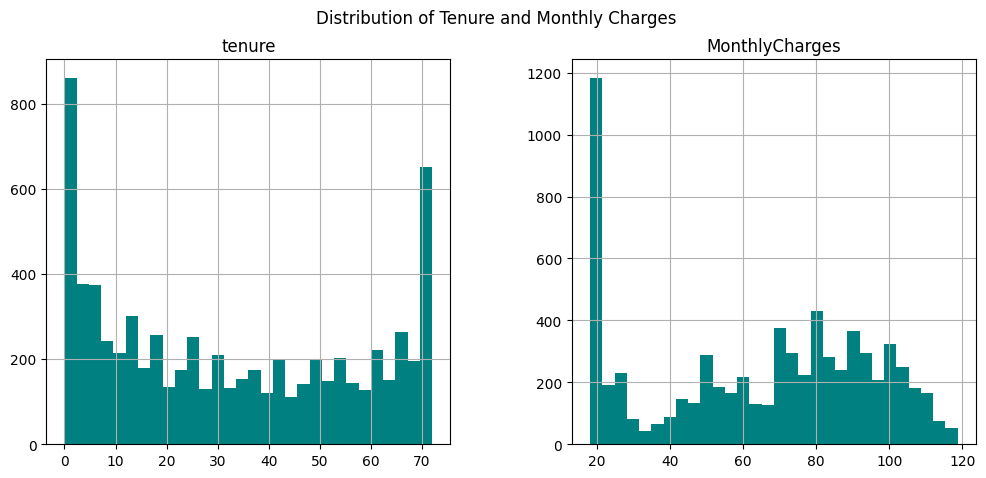

In [ ]:
df[['tenure', 'MonthlyCharges']].hist(bins=30, figsize=(12, 5), color='teal')
plt.suptitle('Distribution of Tenure and Monthly Charges')
plt.show()

# **EDA - Categorical Analysis**
### Comparing churn rates across different contract types to identify trends

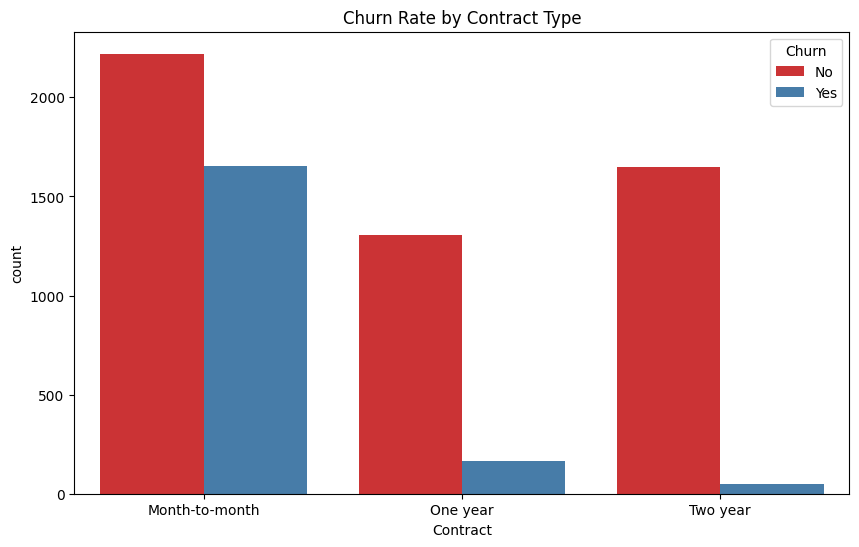

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn', data=df, palette='Set1')
plt.title('Churn Rate by Contract Type')
plt.show()

# **Data Cleaning - Handling TotalCharges**
### Converting TotalCharges from string to numeric and handling empty spaces

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

print("Data cleaning complete: TotalCharges converted and customerID dropped.")

Data cleaning complete: TotalCharges converted and customerID dropped.


# **Feature Engineering**
### Creating synthetic features like 'Tenure Groups' and 'Charges per Month' to provide deeper insights

In [ ]:
def tenure_to_group(t):
    if t <= 12: return '0-1 Year'
    elif t <= 24: return '1-2 Years'
    elif t <= 48: return '2-4 Years'
    else: return 'Over 4 Years'

df['TenureGroup'] = df['tenure'].apply(tenure_to_group)

df['ChargeRatio'] = df['TotalCharges'] / (df['MonthlyCharges'] + 1)

print("Feature Engineering complete: Added TenureGroup and ChargeRatio.")

Feature Engineering complete: Added TenureGroup and ChargeRatio.


# **EDA - Correlation Heatmap**
### Visualizing the relationship between numerical features (after cleaning)

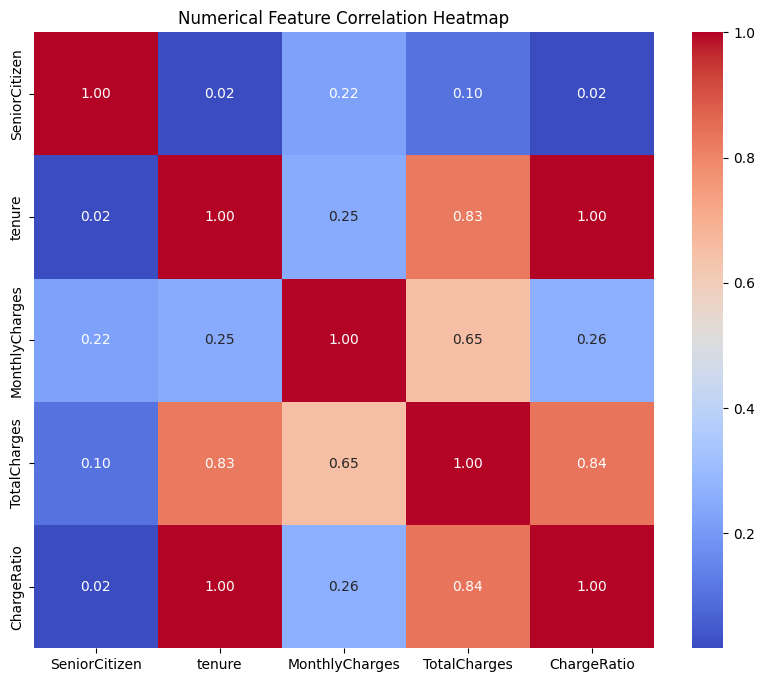

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Numerical Feature Correlation Heatmap')
plt.show()

# **Categorical Encoding & Target Mapping**
### Converting text labels into numbers for model compatibility

In [ ]:
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

df_final = pd.get_dummies(df, drop_first=True)
print(f"Final feature count after encoding: {df_final.shape[1]}")

# **Data Splitting and SMOTE Balancing**
### Splitting the data and applying SMOTE only to the training set to prevent data leakage

In [ ]:
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts().to_dict()}")
print(f"After SMOTE: {y_train_balanced.value_counts().to_dict()}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# **Model 1 - Logistic Regression**
### Training and evaluating Logistic Regression across five key metrics

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train_balanced)

y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

print(f"LR - Test Accuracy : {accuracy_score(y_test, y_test_pred_lr):.4f}")
print(f"LR - Precision     : {precision_score(y_test, y_test_pred_lr):.4f}")
print(f"LR - Recall        : {recall_score(y_test, y_test_pred_lr):.4f}")
print(f"LR - F1 Score      : {f1_score(y_test, y_test_pred_lr):.4f}")

plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_test_pred_lr), annot=True, fmt='d', cmap='Reds')
plt.show()

# **Model 2 - Decision Tree**
### Implementing a Decision Tree and checking for overfitting through depth control

In [ ]:
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_balanced, y_train_balanced)

y_train_pred_dt = dt_model.predict(X_train_balanced)
y_test_pred_dt = dt_model.predict(X_test)

print(f"Decision Tree - Train Accuracy: {accuracy_score(y_train_balanced, y_train_pred_dt):.4f}")
print(f"Decision Tree - Test Accuracy : {accuracy_score(y_test, y_test_pred_dt):.4f}")
print(f"Decision Tree - Precision     : {precision_score(y_test, y_test_pred_dt):.4f}")
print(f"Decision Tree - Recall        : {recall_score(y_test, y_test_pred_dt):.4f}")
print(f"Decision Tree - F1 Score      : {f1_score(y_test, y_test_pred_dt):.4f}")

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_test_pred_dt), annot=True, fmt='d', cmap='Oranges')
plt.title('Decision Tree Confusion Matrix')
plt.show()

# **Model 3 - Random Forest**
### Using an ensemble Random Forest model to optimize performance stability

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

y_train_pred_rf = rf_model.predict(X_train_balanced)
y_test_pred_rf = rf_model.predict(X_test)

print(f"Random Forest - Train Accuracy: {accuracy_score(y_train_balanced, y_train_pred_rf):.4f}")
print(f"Random Forest - Test Accuracy : {accuracy_score(y_test, y_test_pred_rf):.4f}")
print(f"Random Forest - Precision     : {precision_score(y_test, y_test_pred_rf):.4f}")
print(f"Random Forest - Recall        : {recall_score(y_test, y_test_pred_rf):.4f}")
print(f"Random Forest - F1 Score      : {f1_score(y_test, y_test_pred_rf):.4f}")

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_test_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest Confusion Matrix')
plt.show()

# **Final Comparison & Explicit Selection**
### Consolidating all model results to select the final candidate for your GUI application

In [ ]:
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Train Accuracy': [accuracy_score(y_train_balanced, y_train_pred_lr), accuracy_score(y_train_balanced, y_train_pred_dt), accuracy_score(y_train_balanced, y_train_pred_rf)],
    'Test Accuracy': [accuracy_score(y_test, y_test_pred_lr), accuracy_score(y_test, y_test_pred_dt), accuracy_score(y_test, y_test_pred_rf)],
    'Precision': [precision_score(y_test, y_test_pred_lr), precision_score(y_test, y_test_pred_dt), precision_score(y_test, y_test_pred_rf)],
    'Recall': [recall_score(y_test, y_test_pred_lr), recall_score(y_test, y_test_pred_dt), recall_score(y_test, y_test_pred_rf)],
    'F1 Score': [f1_score(y_test, y_test_pred_lr), f1_score(y_test, y_test_pred_dt), f1_score(y_test, y_test_pred_rf)]
}).sort_values(by='Recall', ascending=False)

display(comparison_df)

best_model_name = comparison_df.iloc[0]['Model']
print(f"\nCONCLUSION: The {best_model_name} gave the most stable and balanced results for this dataset ( Based on the recall )")

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score
1,Decision Tree,0.803407,0.771469,0.552361,0.721180,0.625581
2,Random Forest,0.888110,0.792761,0.590604,0.707775,0.643902
0,Logistic Regression,0.831682,0.793471,0.596698,0.678284,0.634881



CONCLUSION: The Decision Tree gave the most stable and balanced results for this dataset ( Based on the recall )


# **Saving All Models, Scaler, and Features**
### Exporting each trained model (Logistic Regression, Decision Tree, and Random Forest) along with the preprocessing tools to local files for GitHub and Deployment

In [ ]:
import joblib
from google.colab import files

joblib.dump(lr_model, 'logistic_regression_model.pkl')
joblib.dump(dt_model, 'decision_tree_model.pkl')
joblib.dump(rf_model, 'random_forest_model.pkl')

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X_train.columns.tolist(), 'model_columns.pkl')

model_files = [
    'logistic_regression_model.pkl',
    'decision_tree_model.pkl',
    'random_forest_model.pkl',
    'scaler.pkl',
    'model_columns.pkl'
]

for file_name in model_files:
    files.download(file_name)

print("All models and preprocessing assets have been prepared for download.")